In [1]:
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pickle
import random
import pandas as pd

import deep_snow.dataset

In [2]:
# get paths to data
train_data_dir = '/mnt/Backups/gbrench/repos/deep-snow/data/subsets_v4/train'
train_path_list = glob(f'{train_data_dir}/ASO_50M_SD*.nc')

val_data_dir = '/mnt/Backups/gbrench/repos/deep-snow/data/subsets_v4/val'
val_path_list = glob(f'{val_data_dir}/ASO_50M_SD*.nc')

In [3]:
# define data to be returned by dataloader
selected_channels = [
    # ASO products
    'aso_sd', # ASO lidar snow depth (target dataset)
    'aso_gap_map', # gaps in ASO data
    
    # Sentinel-1 products
    'snowon_vv', # snow on Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vh', # snow on Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vv', # snow off Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vh', # snow off Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vv_mean', # snow on Sentinel-1 VV polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowon_vh_mean', # snow on Sentinel-1 VH polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowoff_vv_mean', # snow off Sentinel-1 VV polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowoff_vh_mean', # snow off Sentinel-1 VH polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowon_cr', # cross ratio, snowon_vh - snowon_vv
    'snowoff_cr', # cross ratio, snowoff_vh - snowoff_vv
    'delta_cr', # change in cross ratio, snowon_cr - snowoff_cr
    'rtc_gap_map', # gaps in Sentinel-1 data
    'rtc_mean_gap_map', # gaps in Sentinel-1 mean data
    
    # Sentinel-2 products 
    'aerosol_optical_thickness', # snow on Sentinel-2 aerosol optical thickness band 
    'coastal_aerosol', # snow on Sentinel-2 coastal aerosol band
    'blue', # snow on Sentinel-2 blue band
    'green', # snow on Sentinel-2 green band
    'red', # snow on Sentinel-2 red band
    'red_edge1', # snow on Sentinel-2 red edge 1 band
    'red_edge2', # snow on Sentinel-2 red edge 2 band
    'red_edge3', # snow on Sentinel-2 red edge 3 band
    'nir', # snow on Sentinel-2 near infrared band
    'water_vapor', # snow on Sentinel-2 water vapor
    'swir1', # snow on Sentinel-2 shortwave infrared band 1
    'swir2', # snow on Sentinel-2 shortwave infrared band 2
    'scene_class_map', # snow on Sentinel-2 scene classification product
    'water_vapor_product', # snow on Sentinel-2 water vapor product
    'ndvi', # Normalized Difference Vegetation Index from Sentinel-2
    'ndsi', # Normalized Difference Snow Index from Sentinel-2
    'ndwi', # Normalized Difference Water Index from Sentinel-2
    's2_gap_map', # gaps in Sentinel-2 data

    # PROBA-V global land cover dataset (Buchhorn et al., 2020)
    'fcf', # fractional forest cover
    
    # COP30 digital elevation model      
    'elevation',
    'slope',
    'aspect',
    'curvature',
    'tpi',
    'tri',

    # latitude and longitude
    'latitude',
    'longitude',

    # day of water year
    'dowy'
                    ]

In [4]:
# define input channels for model
selected_channels = [
    'snowon_vv',
    'snowon_vh',
    'snowoff_vv',
    'snowoff_vh',
    'snowon_cr',
    'snowoff_cr',
    'delta_cr',
    'blue',
    'green',
    'red',
    'nir',
    'swir1',
    'swir2',
    'ndvi',
    'ndsi',
    'ndwi',
    'fcf',
    'elevation',
    'slope',
    'aspect',
    'curvature',
    'tri',
    'tpi',
    'latitude',
    'longitude',
    'dowy',
    'aso_gap_map',
    'rtc_gap_map',
    's2_gap_map']

In [5]:
val_data = deep_snow.dataset.Dataset(val_path_list, selected_channels, norm=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=16, shuffle=True, num_workers=16)

In [6]:
all_data = []

for i, data_tuple in enumerate(val_loader):
    # read data into dictionary
    data_dict = {name: tensor.flatten().numpy() for name, tensor in zip(selected_channels, data_tuple)}
    if i == 0:
        df = pd.DataFrame.from_dict(data_dict)
    else:
        df = pd.concat([df, pd.DataFrame.from_dict(data_dict)], ignore_index=True)

In [7]:
# mask gaps
df['all_gaps'] = df[['aso_gap_map', 'rtc_gap_map', 's2_gap_map']].sum(axis=1)
df = df[df['all_gaps'] <= 0]
df = df.drop(columns=['all_gaps', 'aso_gap_map', 'rtc_gap_map', 's2_gap_map', 'aspect'])

In [8]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
pca.fit(df)

# Get the loadings (coefficients)
loadings = pca.components_.T

# Create a DataFrame with the loadings
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=df.columns)

/tmp/ipykernel_6999/1944010554.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0].annotate(txt, (loadings_df['PC1'][i], loadings_df['PC2'][i]), fontsize=10, alpha=0.8)
/tmp/ipykernel_6999/1944010554.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[1].annotate(txt, (loadings_df['PC1'][i], loadings_df['PC2'][i]), fontsize=10, alpha=0.8)


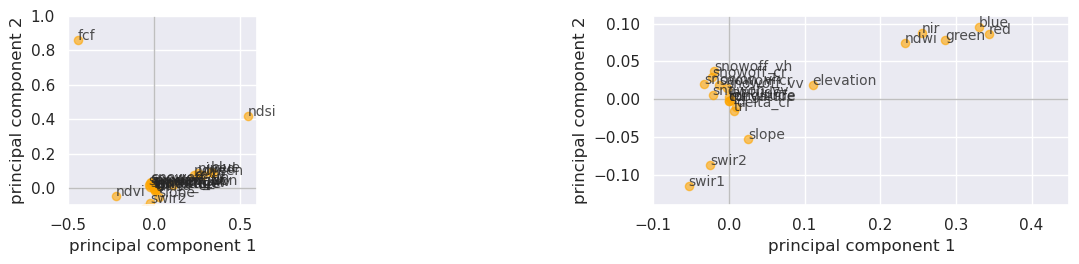

In [15]:
sns.set_theme()

# Plot the loadings using plt.subplots()
fig, ax = plt.subplots(1, 2, figsize=(15, 2.8))
ax[0].axhline(0, c='grey', linewidth=1, zorder=1, alpha=0.5)
ax[0].axvline(0, c='grey', linewidth=1, zorder=1, alpha=0.5)
ax[1].axhline(0, c='grey', linewidth=1, zorder=1, alpha=0.5)
ax[1].axvline(0, c='grey', linewidth=1, zorder=1, alpha=0.5)
ax[0].scatter(loadings_df['PC1'], loadings_df['PC2'], s=35, c='orange', alpha=0.6)
ax[1].scatter(loadings_df['PC1'], loadings_df['PC2'], s=35, c='orange', alpha=0.6)

# Label each point with the variable name
for i, txt in enumerate(loadings_df.index):
    ax[0].annotate(txt, (loadings_df['PC1'][i], loadings_df['PC2'][i]), fontsize=10, alpha=0.8)
    ax[1].annotate(txt, (loadings_df['PC1'][i], loadings_df['PC2'][i]), fontsize=10, alpha=0.8)

ax[0].set_xlabel('principal component 1')
ax[0].set_ylabel('principal component 2')
ax[1].set_xlabel('principal component 1')
ax[1].set_ylabel('principal component 2')
# ax[0].set_ylim(-0.1, 1)
# ax[0].set_xlim(-0.5, 0.6)
# ax[1].set_ylim(-0.05, 0.07)
# ax[1].set_xlim(-0.1, 0.37)

ax[0].set_ylim(-0.1, 1)
ax[0].set_xlim(-0.5, 0.6)
ax[1].set_ylim(-0.14, 0.11)
ax[1].set_xlim(-0.1, 0.45)
ax[0].grid(True)
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[1].grid(True)
plt.tight_layout()

#plt.savefig('../../figs/val_pca.png', dpi=300)

/tmp/ipykernel_881/2277332395.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(loadings_df['PC1'][i], loadings_df['PC2'][i], loadings_df['PC3'][i], txt)


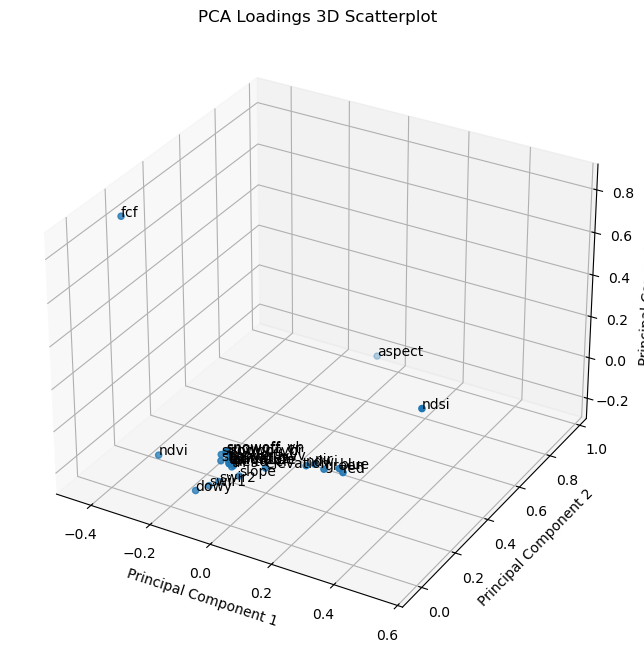

In [22]:
from mpl_toolkits.mplot3d import Axes3D

# Perform PCA
pca = PCA(n_components=3)
pca.fit(df)

# Get the loadings (coefficients)
loadings = pca.components_.T

# Create a DataFrame with the loadings
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3'], index=df.columns)

# Plot the loadings using plt.subplots()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(loadings_df['PC1'], loadings_df['PC2'], loadings_df['PC3'])

# Label each point with the variable name
for i, txt in enumerate(loadings_df.index):
    ax.text(loadings_df['PC1'][i], loadings_df['PC2'][i], loadings_df['PC3'][i], txt)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA Loadings 3D Scatterplot')
ax.grid(True)

In [13]:
pca_df

,PC1,PC2
0,0.395795,-0.455208
1,0.400593,-0.384770
2,0.410271,-0.445397
3,0.483109,0.297071
4,0.465282,0.288157
...,...,...
178234,0.291639,-0.304748
178235,0.286127,-0.358186
178236,0.282998,-0.457881
178237,0.334893,-0.444487
